## Note
The paramters in this sample code are similar to  our main training code but we test this code on limited number of data for the sake of speed


## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data directory 

In [4]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

In [3]:
# Splite data for Health (h) class
h_path = file_paths[55:110]
print(h_path)

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0001_288_270_368_normal001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0002_334_334_370_normal002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0003_338_344_393_normal003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0004_256_258_340_normal004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0005_286_252_310_normal005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0006_288_237_321_normal006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0007_284_372_368_normal007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0008_278_266_337_normal008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0009_290_292_365_normal009.npy', '/content/drive/MyDrive/googledrive_

## BCDU-net

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.engine.base_layer import Layer


# Tensorflow implementations of max_pooling and unpooling


def max_pool_with_argmax(net, ksize, strides):
  assert isinstance(ksize, list) or isinstance(ksize, int)
  assert isinstance(strides, list) or isinstance(strides, int)

  ksize = ksize if isinstance(ksize, list) else [1, ksize, ksize, 1]
  strides = strides if isinstance(strides, list) else [1, strides, strides, 1]

  with tf.name_scope('MaxPoolArgMax'):
    net, mask = tf.nn.max_pool_with_argmax(
      net,
      ksize=ksize,
      strides=strides,
      padding='SAME')
    return net, mask


def unpool(pool, ind, ksize=[1, 2, 2, 1], scope='unpool'):
    """
       Unpooling layer after max_pool_with_argmax.
       Args:
           pool:   max pooled output tensor
           ind:      argmax indices
           ksize:     ksize is the same as for the pool
       Return:
           unpool:    unpooling tensor
    """
    with tf.compat.v1.variable_scope(scope):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret


def _upsample_along_axis(volume, axis, stride, mode='ZEROS'):
  shape = volume.get_shape().as_list()

  assert mode in ['COPY', 'ZEROS']
  assert 0 <= axis < len(shape)

  target_shape = shape[:]
  target_shape[axis] *= stride

  padding = tf.zeros(shape, dtype=volume.dtype) if mode == 'ZEROS' else volume
  parts = [volume] + [padding for _ in range(stride - 1)]
  volume = tf.concat(parts, min(axis+1, len(shape)-1))

  volume = tf.reshape(volume, target_shape)
  return volume


def upsample(net, stride, mode='ZEROS'):
  """
  Imitate reverse operation of Max-Pooling by either placing original max values
  into a fixed postion of upsampled cell:
  [0.9] =>[[.9, 0],   (stride=2)
           [ 0, 0]]
  or copying the value into each cell:
  [0.9] =>[[.9, .9],  (stride=2)
           [ .9, .9]]
  :param net: 4D input tensor with [batch_size, width, heights, channels] axis
  :param stride:
  :param mode: string 'ZEROS' or 'COPY' indicating which value to use for undefined cells
  :return:  4D tensor of size [batch_size, width*stride, heights*stride, channels]
  """
  assert mode in ['COPY', 'ZEROS']
  with tf.name_scope('Upsampling'):
    net = _upsample_along_axis(net, 2, stride, mode=mode)
    net = _upsample_along_axis(net, 1, stride, mode=mode)
    return net


# Keras layers for pooling and unpooling


class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            strides = [1, strides[0], strides[1], 1]
            output, argmax = max_pool_with_argmax(inputs, ksize, strides)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model



def segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid"):
    # encoder
    inputs = Input(input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)


    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [5]:
model = segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid")
model.summary()

Build enceder done..
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
___________________________________________________

### Resizing the slices for BCDUNet model

In [6]:
from skimage.transform import resize

In [7]:
output = np.zeros((1,128,128))
for i in tqdm(h_path):
    data = np.load(i)
    data = resize(data, (data.shape[0],128, 128),anti_aliasing=True)
    output = np.append(output,data,axis=0)
output = output[1:]

100%|██████████| 55/55 [04:07<00:00,  4.49s/it]


In [8]:
'''
For saving the RAM, you can save the data and restart you runtime.
please import librarys again to continue
'''
np.save('/content/drive/My Drive/googledrive_segmentation/output_segnet.npy',output)


In [9]:
output = np.load('/content/drive/My Drive/googledrive_segmentation/output_segnet.npy')

### Adding noise

In [10]:
!pip install noise

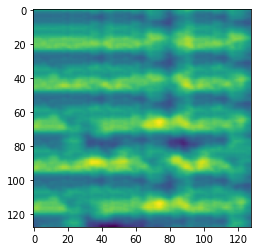

In [11]:
import noise
import cv2
import numpy as np

def add_noise(input_array):
    shape = (128,128)
    scale = np.random.randint(10,30)
    # scale = 12
    # scale = 30
    octaves = 10
    persistence = 0.01*np.random.randint(-50,50)
    # persistence = 0.1
    lacunarity = 2.0
    seed = np.random.randint(0,1000)
    # seed = 33
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=140, 
                                        repeaty=140, 
                                        base=seed)
    return cv2.addWeighted(input_array, 1, world, 1, 0)  

import matplotlib.pyplot as plt
a  = np.zeros((128,128))
plt.imshow(add_noise(a)) 

In [12]:
from tqdm import tqdm
noisy_output = np.zeros(output.shape)
for i in tqdm(range(output.shape[0])):
    noisy_output[i] = add_noise(output[i,:,:])

100%|██████████| 16448/16448 [07:51<00:00, 34.90it/s]


In [13]:
np.save('/content/drive/My Drive/googledrive_segmentation/noisy_output_segnet.npy',noisy_output)

In [14]:
noisy_output = np.load('/content/drive/My Drive/googledrive_segmentation/noisy_output_segnet.npy')

In [ ]:
output = np.load('/content/drive/My Drive/googledrive_segmentation/output_segnet.npy')

In [14]:
'''
Change half of data to original slices (without noise)
Suggestion: you can use random permutation to clean half of data
suggestyion: you can change the rate of being nosisy or clean! 
'''
noisy_output[int(noisy_output.shape[0]/2):] = output[int(noisy_output.shape[0]/2):]

In [15]:
#target (without noise)
output = np.reshape(output,(output.shape[0],output.shape[1],output.shape[2],1))

#input (half noisy)
noisy_output = np.reshape(noisy_output,(noisy_output.shape[0],noisy_output.shape[1],noisy_output.shape[2],1))

### Training the model

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(noisy_output, output,
            batch_size = 5,
            epochs = 3,
            shuffle=True,
            verbose=1)

Epoch 1/3
3290/3290 [==============================] - 327s 88ms/step - loss: 0.4473 - accuracy: 0.7696
Epoch 2/3
3290/3290 [==============================] - 294s 89ms/step - loss: 0.1238 - accuracy: 0.7837
Epoch 3/3
3290/3290 [==============================] - 294s 89ms/step - loss: 0.0885 - accuracy: 0.7816


In [18]:
'''
However, you can save weights of your model for future use
'''
model.save_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_segnet.hdf5')


restart kernel

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.engine.base_layer import Layer


# Tensorflow implementations of max_pooling and unpooling


def max_pool_with_argmax(net, ksize, strides):
  assert isinstance(ksize, list) or isinstance(ksize, int)
  assert isinstance(strides, list) or isinstance(strides, int)

  ksize = ksize if isinstance(ksize, list) else [1, ksize, ksize, 1]
  strides = strides if isinstance(strides, list) else [1, strides, strides, 1]

  with tf.name_scope('MaxPoolArgMax'):
    net, mask = tf.nn.max_pool_with_argmax(
      net,
      ksize=ksize,
      strides=strides,
      padding='SAME')
    return net, mask


def unpool(pool, ind, ksize=[1, 2, 2, 1], scope='unpool'):
    """
       Unpooling layer after max_pool_with_argmax.
       Args:
           pool:   max pooled output tensor
           ind:      argmax indices
           ksize:     ksize is the same as for the pool
       Return:
           unpool:    unpooling tensor
    """
    with tf.compat.v1.variable_scope(scope):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret


def _upsample_along_axis(volume, axis, stride, mode='ZEROS'):
  shape = volume.get_shape().as_list()

  assert mode in ['COPY', 'ZEROS']
  assert 0 <= axis < len(shape)

  target_shape = shape[:]
  target_shape[axis] *= stride

  padding = tf.zeros(shape, dtype=volume.dtype) if mode == 'ZEROS' else volume
  parts = [volume] + [padding for _ in range(stride - 1)]
  volume = tf.concat(parts, min(axis+1, len(shape)-1))

  volume = tf.reshape(volume, target_shape)
  return volume


def upsample(net, stride, mode='ZEROS'):
  """
  Imitate reverse operation of Max-Pooling by either placing original max values
  into a fixed postion of upsampled cell:
  [0.9] =>[[.9, 0],   (stride=2)
           [ 0, 0]]
  or copying the value into each cell:
  [0.9] =>[[.9, .9],  (stride=2)
           [ .9, .9]]
  :param net: 4D input tensor with [batch_size, width, heights, channels] axis
  :param stride:
  :param mode: string 'ZEROS' or 'COPY' indicating which value to use for undefined cells
  :return:  4D tensor of size [batch_size, width*stride, heights*stride, channels]
  """
  assert mode in ['COPY', 'ZEROS']
  with tf.name_scope('Upsampling'):
    net = _upsample_along_axis(net, 2, stride, mode=mode)
    net = _upsample_along_axis(net, 1, stride, mode=mode)
    return net


# Keras layers for pooling and unpooling


class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            strides = [1, strides[0], strides[1], 1]
            output, argmax = max_pool_with_argmax(inputs, ksize, strides)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model



def segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid"):
    # encoder
    inputs = Input(input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)


    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

model = segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid")

Build enceder done..
Build decoder done..


In [3]:
model.load_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_segnet.hdf5')

## 3D CNN model

In [4]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

In [5]:
'''
Load all data to pass through BCDUNet to bold infections in out pipeline
Splite data for each class of COVID (c), Health or Control (h) and Pneumonia or CAP (p)

'''
c_path = file_paths[:55]
h_path = file_paths[55:110]
p_path = file_paths[110:165]
my_file_paths = c_path+h_path+p_path
print(my_file_paths)
print(len(my_file_paths))


['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

### Go Through BCDUNet all slices and pack them

In [ ]:
'''
Here, we:
1- Resize different size of slices (2D) -> in x,y axes
2- Predict all slices of a patient using BCDUNET
3- Do subtraction
1- Resize different size of CT images (3D) -> in z axis
'''
from skimage.transform import resize
import numpy as np
from scipy import signal

dataset = np.zeros((len(my_file_paths),50,128,128))
counter = 0
for j in tqdm(my_file_paths):
    #print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    #out_resized = resize(out, (out.shape[0],128, 128),anti_aliasing=True)
    c = CT_resized-out[:,:,:,0]
    dataset[counter] = resize(c,(50,128,128))
    counter +=1

  0%|          | 0/165 [00:00<?, ?it/s]

### Prepare labels

In [ ]:
'''
Based on the name of files (C: COVID, H: Health or Control, P: Pneumonia or CAP)
'''
lbl = np.zeros((165))
lbl[0:55] = 1 #COVID
lbl[55:110] = 0 #Control
lbl[110:165] = 2 #CAP
print(lbl)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [ ]:
'''
For saving the RAM, you can save the data and restart you runtime.
please import librarys again to continue
'''
np.save('/content/drive/My Drive/googledrive_segmentation/dataset_segnet.npy',dataset)
np.save('/content/drive/My Drive/googledrive_segmentation/lbl_segnet.npy',lbl)

### 3D CNN training

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = np.load('/content/drive/My Drive/googledrive_segmentation/dataset_segnet.npy')
lbl = np.load('/content/drive/My Drive/googledrive_segmentation/lbl_segnet.npy')

In [ ]:
# reshape the dataset to feed to the model
dataset = np.reshape(dataset,(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3],1))

In [ ]:
# for balancing data as the inputs of the model
c = np.random.permutation(np.arange(0,55))
h = np.random.permutation(np.arange(55,110))
p = np.random.permutation(np.arange(110,165))

train_index=[]

train_index = np.append(train_index,c[0:40] ).astype(np.uint8)
train_index = np.append(train_index,p[0:40]).astype(np.uint8)
train_index = np.random.permutation(train_index)
print('training set:', train_index)

validation_index=[]

validation_index= np.append(validation_index,c[40:55]).astype(np.uint8)
validation_index= np.append(validation_index,p[40:55]).astype(np.uint8)
validation_index= np.random.permutation(validation_index)
print('validation set:', validation_index)



training set: [158  10  39  21  15  46 149  24   2 129 157  25  41 114   4  35 116  45
 110  38  17 123 148 125 131 120  43 133  14  19 154  33 161  37  18 136
   6 146 134 152 162  48  27  53 156  30  47 155 130  22  54  20 160  36
 150   8 118 122 164  16  29 115 147  40  28  26   9 137 135 143 128  50
 138 144   3 142 121 111 112  23]
validation set: [ 42 132  49 117 141  32  52 140  44 153  11  13 163 113 139   0 127   5
  12 124 119 126 145  31   1 151   7  51 159  34]


In [ ]:
# Convert target vectors to categorical targets
targets_train = to_categorical(lbl[train_index]).astype(np.uint8)
targets_validation = to_categorical(lbl[validation_index]).astype(np.uint8)


In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50,128,128,1)))
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 48, 126, 126, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 126, 126, 8)   1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 24, 63, 63, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 63, 63, 16)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 63, 63, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 31, 31, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 31, 31, 32)    1

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, # or 'mse'
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


In [ ]:
# Fit data to model
history = model.fit(dataset[train_index], targets_train,
            batch_size=10, # batch_size = 16 in paper
            epochs=100, # epochs = 100 in paper
            verbose=1,
            shuffle = True,
            validation_data = (dataset[validation_index],targets_validation))

Epoch 1/100
8/8 [==============================] - 8s 690ms/step - loss: 1.0337 - accuracy: 0.4082 - val_loss: 0.8430 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 3s 370ms/step - loss: 0.8739 - accuracy: 0.5412 - val_loss: 0.7016 - val_accuracy: 0.5667
Epoch 3/100
8/8 [==============================] - 3s 368ms/step - loss: 0.6768 - accuracy: 0.6934 - val_loss: 0.7134 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 3s 363ms/step - loss: 0.8104 - accuracy: 0.4925 - val_loss: 0.7260 - val_accuracy: 0.5667
Epoch 5/100
8/8 [==============================] - 3s 364ms/step - loss: 0.7411 - accuracy: 0.6312 - val_loss: 0.7318 - val_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 3s 363ms/step - loss: 0.6992 - accuracy: 0.6220 - val_loss: 0.6947 - val_accuracy: 0.6333
Epoch 7/100
8/8 [==============================] - 3s 363ms/step - loss: 0.7054 - accuracy: 0.6438 - val_loss: 0.6884 - val_accuracy: 0.5667
Epoch 8/100
8

In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(targets_validation.argmax(axis=1), model.predict(dataset[validation_index]).argmax(axis=1))
print(matrix)

[[9 6]
 [6 9]]


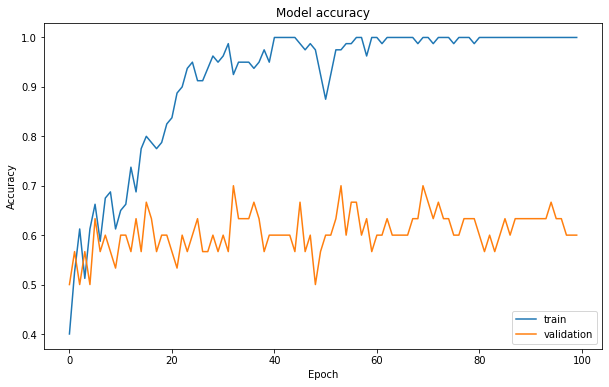

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

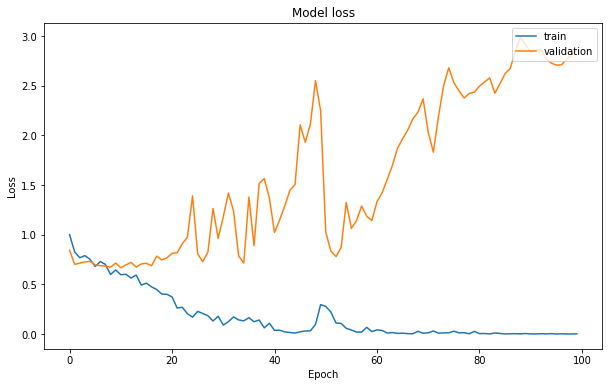

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### saving

In [ ]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/googledrive_segmentation/weight_cnn_CovidCtNet2d.h5")